MISA 3D Brain MRI Segmentation using 2D UNet

1. Preprocessing - Bias Correction

2. Method - Patch Based

3. Data Augmentation - Yes

# Importing the Libraries

In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt # plotting purposes
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
import glob
import cv2
import scipy.misc
from scipy import ndimage
import SimpleITK as sitk
import keras.backend as K

Init Plugin
Init Graph Optimizer
Init Kernel


# Defining the Parameters

In [2]:
#Keras
ALPHA = 0.5
BETA = 0.5

###################################
#           Tversky loss          #
###################################

def TverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, smooth=1e-6):
        
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky
    
#Keras
ALPHA = 0.5
BETA = 0.5
GAMMA = 1

########################################
#           FocalTversky loss          #
########################################

def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    
    
#Keras
ALPHA = 0.8
GAMMA = 2

#################################
#           Focal loss          #
#################################

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss


################################
#           Dice loss          #
################################

#Keras
# Helper function to enable loss function to be flexibly used for 
# both 2D or 3D image segmentation - source: https://github.com/frankkramer-lab/MIScnn
def identify_axis(shape):
    # Three dimensional
    if len(shape) == 5 : return [1,2,3]
    # Two dimensional
    elif len(shape) == 4 : return [1,2]
    # Exception - Unknown
    else : raise ValueError('Metric: Shape of tensor is neither 2D or 3D.')


def DiceLoss(y_true, y_pred, delta = 0.5, smooth = 0.000001):
    axis = identify_axis(y_true.get_shape())
    # Calculate true positives (tp), false negatives (fn) and false positives (fp)
    tp = K.sum(y_true * y_pred, axis=axis)
    fn = K.sum(y_true * (1-y_pred), axis=axis)
    fp = K.sum((1-y_true) * y_pred, axis=axis)
    # Calculate Dice score
    dice_class = (tp + smooth)/(tp + delta*fn + (1-delta)*fp + smooth)
    # Average class scores
    dice_loss = K.mean(1-dice_class)

    return dice_loss

###############################
#          Combo loss         #
###############################


def ComboLoss(y_true, y_pred, alpha=0.5, beta=0.5):
    
    dice = DiceLoss(y_true, y_pred)
    axis = identify_axis(y_true.get_shape())
    # Clip values to prevent division by zero error
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * K.log(y_pred)

    if beta is not None:
        beta_weight = np.array([beta, 1-beta])
        cross_entropy = beta_weight * cross_entropy
    # sum over classes
    cross_entropy = K.mean(K.sum(cross_entropy, axis=[-1]))
    if alpha is not None:
        combo_loss = (alpha * cross_entropy) - ((1 - alpha) * dice)
    else:
        combo_loss = cross_entropy - dice
    return combo_loss
 

In [3]:
# dataset parameters
IMAGE_SIZE = (256, 128, 256)

# training, validation, test parameters
TRAINING_VOLUMES = [0, 1, 2, 3, 4, 5, 6, 7, 8]
VALIDATION_VOLUMES = [9]

# network parameters
N_CLASSES = 4
N_INPUT_CHANNELS = 1
PATCH_SIZE = (32, 32)
PATCH_STRIDE = (32, 32)

# data preparation parameters
CONTENT_THRESHOLD = 0.3 # to get rid of useless info in the image

# training parameters
N_EPOCHS = 200
BATCH_SIZE = 64
PATIENCE = 20
MODEL_FNAME_PATTERN = 'model-200-categorical_crossentropy.h5'
OPTIMISER = 'Adam'
LOSS = 'categorical_crossentropy'
dropout_rate = 0.40

list_id = []

**Mount drive**

In [4]:
#from google.colab import drive
#drive._mount("/content/drive")

# Define UNet Architecture

In [5]:
# model
def get_unet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scale=1):
    inputs = keras.Input(shape=img_size + (n_input_channels, ))

    # Encoding path
    conv1 = layers.Conv2D(32*scale, (3, 3), padding="same", activation='relu')(inputs)
    drop1 = layers.Dropout(rate=dropout_rate)(conv1, training=True)
    max1 = layers.MaxPooling2D((2, 2))(drop1)
    # max1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(64*scale, (3, 3), padding="same", activation='relu')(max1)
    drop2 = layers.Dropout(rate=dropout_rate)(conv2, training=True)
    # max2 = layers.MaxPooling2D((2, 2))(conv2)
    max2 = layers.MaxPooling2D((2, 2))(drop2)

    conv3 = layers.Conv2D(128*scale, (3, 3), padding="same", activation='relu')(max2)
    drop3 = layers.Dropout(rate=dropout_rate)(conv3, training=True)
    # max3 = layers.MaxPooling2D((2, 2))(conv3)
    max3 = layers.MaxPooling2D((2, 2))(drop3)

    lat = layers.Conv2D(256*scale, (3, 3), padding="same", activation='relu')(max3)
    drop4 = layers.Dropout(rate=dropout_rate)(lat, training=True)

    # Decoding path
    #up1 = layers.UpSampling2D((2, 2))(lat)
    up1 = layers.UpSampling2D((2, 2))(drop4)
    concat1 = layers.concatenate([conv3, up1], axis=-1)
    conv4 = layers.Conv2D(128*scale, (3, 3), padding="same", activation='relu')(concat1)
    drop5 = layers.Dropout(rate=dropout_rate)(conv4, training=True)
    
    #up2 = layers.UpSampling2D((2, 2))(conv4)
    up2 = layers.UpSampling2D((2, 2))(drop5)
    concat2 = layers.concatenate([conv2, up2], axis=-1)
    conv5 = layers.Conv2D(64*scale, (3, 3), padding="same", activation='relu')(concat2)
    drop6 = layers.Dropout(rate=dropout_rate)(conv5, training=True)
    
    #up3 = layers.UpSampling2D((2, 2))(conv5)
    up3 = layers.UpSampling2D((2, 2))(drop6)
    concat3 = layers.concatenate([conv1, up3], axis=-1)
    conv6 = layers.Conv2D(32*scale, (3, 3), padding="same", activation='relu')(concat3)
    drop7 = layers.Dropout(rate=dropout_rate)(conv6, training=True)
    
    #outputs = layers.Conv2D(n_classes, (1, 1), activation="softmax")(conv6)
    outputs = layers.Conv2D(n_classes, (1, 1), activation="softmax")(drop7)

    model = keras.Model(inputs, outputs)

    return model


"""
def get_res_unet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scale=1):
    inputs = keras.Input(shape=img_size + (n_input_channels, ))

    # Encoding Path of the ResUNet (32-64-128-256-512)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conc1 = concatenate([inputs, conv1], axis=3)
    drop1 = Dropout(rate=dropout_rate)(conc1, training=True)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conc2 = concatenate([pool1, conv2], axis=3)
    drop2 = Dropout(rate=dropout_rate)(conc2, training=True)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conc3 = concatenate([pool2, conv3], axis=3)
    drop3 = Dropout(rate=dropout_rate)(conc3, training=True)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conc4 = concatenate([pool3, conv4], axis=3)
    drop4 = Dropout(rate=dropout_rate)(conc4, training=True)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conc5 = concatenate([pool4, conv5], axis=3)
    drop5 = Dropout(rate=dropout_rate)(conc5, training=True)

    # Decoding Path of the ResUNet
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(drop5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conc6 = concatenate([up6, conv6], axis=3)
    drop6 = Dropout(rate=dropout_rate)(conc6, training=True)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(drop6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conc7 = concatenate([up7, conv7], axis=3)
    drop7 = Dropout(rate=dropout_rate)(conc7, training=True)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(drop7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conc8 = concatenate([up8, conv8], axis=3)
    drop8 = Dropout(rate=dropout_rate)(conc8, training=True)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(drop8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conc9 = concatenate([up9, conv9], axis=3)
    drop9 = Dropout(rate=dropout_rate)(conc9, training=True)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(drop9)

    model = Model(inputs, outputs)

    return model
"""

"""
def get_dense_unet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scale=1):
    inputs = keras.Input(shape=img_size + (n_input_channels, ))

    # Encoding Path of the DenseUNet (32-64-128-256-512)
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conc11 = concatenate([inputs, conv11], axis=3)
    conv12 = Conv2D(32, (3, 3), activation='relu', padding='same')(conc11)
    conc12 = concatenate([inputs, conv12], axis=3)
    drop1 = Dropout(rate=dropout_rate)(conc12, training=True)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)

    conv21 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conc21 = concatenate([pool1, conv21], axis=3)
    conv22 = Conv2D(64, (3, 3), activation='relu', padding='same')(conc21)
    conc22 = concatenate([pool1, conv22], axis=3)
    drop2 = Dropout(rate=dropout_rate)(conc22, training=True)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)

    conv31 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conc31 = concatenate([pool2, conv31], axis=3)
    conv32 = Conv2D(128, (3, 3), activation='relu', padding='same')(conc31)
    conc32 = concatenate([pool2, conv32], axis=3)
    drop3 = Dropout(rate=dropout_rate)(conc32, training=True)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

    conv41 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conc41 = concatenate([pool3, conv41], axis=3)
    conv42 = Conv2D(256, (3, 3), activation='relu', padding='same')(conc41)
    conc42 = concatenate([pool3, conv42], axis=3)
    drop4 = Dropout(rate=dropout_rate)(conc42, training=True)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv51 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conc51 = concatenate([pool4, conv51], axis=3)
    conv52 = Conv2D(512, (3, 3), activation='relu', padding='same')(conc51)
    conc52 = concatenate([pool4, conv52], axis=3)
    drop5 = Dropout(rate=dropout_rate)(conc52, training=True)

    # Decoding Path of the ResUNet
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(drop5), conc42], axis=3)
    conv61 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conc61 = concatenate([up6, conv61], axis=3)
    conv62 = Conv2D(256, (3, 3), activation='relu', padding='same')(conc61)
    conc62 = concatenate([up6, conv62], axis=3)
    drop6 = Dropout(rate=dropout_rate)(conc62, training=True)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(drop6), conv32], axis=3)
    conv71 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conc71 = concatenate([up7, conv71], axis=3)
    conv72 = Conv2D(128, (3, 3), activation='relu', padding='same')(conc71)
    conc72 = concatenate([up7, conv72], axis=3)
    drop7 = Dropout(rate=dropout_rate)(conc72, training=True)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(drop7), conv22], axis=3)
    conv81 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conc81 = concatenate([up8, conv81], axis=3)
    conv82 = Conv2D(64, (3, 3), activation='relu', padding='same')(conc81)
    conc82 = concatenate([up8, conv82], axis=3)
    drop8 = Dropout(rate=dropout_rate)(conc82, training=True)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(drop8), conv12], axis=3)
    conv91 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conc91 = concatenate([up9, conv91], axis=3)
    conv92 = Conv2D(32, (3, 3), activation='relu', padding='same')(conc91)
    conc92 = concatenate([up9, conv92], axis=3)
    drop9 = Dropout(rate=dropout_rate)(conc92, training=True)

    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(drop9)

    model = Model(inputs, outputs)

    return model
"""
"""
def get_deep_unet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scale=1):
    inputs = keras.Input(shape=img_size + (n_input_channels, ))

    # Encoding Path of the UNet (32-64-128-256-512)
    conv1   = Conv2D(32*scale, (3, 3), padding="same", activation='relu')(inputs)
    drop1   = Dropout(rate=dropout_rate)(conv1, training=True)
    max1    = MaxPooling2D((2, 2))(drop1)

    conv2   = Conv2D(64*scale, (3, 3), padding="same", activation='relu')(max1)
    drop2   = Dropout(rate=dropout_rate)(conv2, training=True)
    max2    = MaxPooling2D((2, 2))(drop2)

    conv3   = Conv2D(128*scale, (3, 3), padding="same", activation='relu')(max2)
    drop3   = Dropout(rate=dropout_rate)(conv3, training=True)
    max3    = MaxPooling2D((2, 2))(drop3)

    conv4   = Conv2D(256*scale, (3, 3), padding="same", activation='relu')(max3)
    drop4   = Dropout(rate=dropout_rate)(conv4, training=True)
    max4    = MaxPooling2D((2, 2))(drop4)

    lat     = Conv2D(512*scale, (3, 3), padding="same", activation='relu')(max4)
    drop5   = Dropout(rate=dropout_rate)(lat, training=True)

    # Decoding Path of the UNet
    up1     = UpSampling2D((2, 2))(drop5)
    concat1 = concatenate([conv4, up1], axis=-1)
    conv5   = Conv2D(256*scale, (3, 3), padding="same", activation='relu')(concat1)
    drop6   = Dropout(rate=dropout_rate)(conv5, training=True)
    
    up2     = UpSampling2D((2, 2))(drop6)
    concat2 = concatenate([conv3, up2], axis=-1)
    conv6   = Conv2D(128*scale, (3, 3), padding="same", activation='relu')(concat2)
    drop7   = Dropout(rate=dropout_rate)(conv6, training=True)
    
    up3     = UpSampling2D((2, 2))(drop7)
    concat3 = concatenate([conv2, up3], axis=-1)
    conv7   = Conv2D(64*scale, (3, 3), padding="same", activation='relu')(concat3)
    drop8   = Dropout(rate=dropout_rate)(conv7, training=True)

    up4     = UpSampling2D((2, 2))(drop8)
    concat4 = concatenate([conv1, up4], axis=-1)
    conv8   = Conv2D(32*scale, (3, 3), padding="same", activation='relu')(concat4)
    drop9   = Dropout(rate=dropout_rate)(conv8, training=True)
    
    outputs = Conv2D(n_classes, (1, 1), activation="softmax")(drop9)

    model   = Model(inputs, outputs)

    return model
"""

'\n# new-model\ndef get_unet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scale=1):\n    \n    inputs = keras.Input(shape=img_size + (n_input_channels, ))\n\n    # Encoding Path of the UNet (32-64-128-256-512)\n    conv1   = layers.Conv2D(32*scale, (3, 3), padding="same", activation=\'relu\')(inputs)\n    drop1   = layers.Dropout(rate=dropout_rate)(conv1, training=True)\n    max1    = layers.MaxPooling2D((2, 2))(drop1)\n\n    conv2   = layers.Conv2D(64*scale, (3, 3), padding="same", activation=\'relu\')(max1)\n    drop2   = layers.Dropout(rate=dropout_rate)(conv2, training=True)\n    max2    = layers.MaxPooling2D((2, 2))(drop2)\n\n    conv3   = layers.Conv2D(128*scale, (3, 3), padding="same", activation=\'relu\')(max2)\n    drop3   = layers.Dropout(rate=dropout_rate)(conv3, training=True)\n    max3    = layers.MaxPooling2D((2, 2))(drop3)\n\n    conv4   = layers.Conv2D(256*scale, (3, 3), padding="same", activation=\'relu\')(max3)\n    drop4   = layers.Dro

# Generate Bias Corrected Images

In [6]:
"""
def N4(inputImagePath, maskImagePath, outputPath):
  # inputImagePath = input('Enter the path of the image : ')
  inputImage = sitk.ReadImage(inputImagePath)

  print("N4 bias correction runs.")

  # maskImage = sitk.ReadImage("06-t1c_mask.nii.gz")
  maskImage = sitk.OtsuThreshold(inputImage,0,1,200)
  maskImagePath = input('Enter the name of the mask image to be saved : ')
  sitk.WriteImage(maskImage, maskImagePath)
  print("Mask image is saved.")

  inputImage = sitk.Cast(inputImage,sitk.sitkFloat32)

  corrector = sitk.N4BiasFieldCorrectionImageFilter();

  output = corrector.Execute(inputImage,maskImage)

  outputPath = input("Enter the name of the Bias Field Corrected Image :")
  sitk.WriteImage(output,outputPath)
  print("Finished N4 Bias Field Correction.....")
"""

'\ndef N4(inputImagePath, maskImagePath, outputPath):\n  # inputImagePath = input(\'Enter the path of the image : \')\n  inputImage = sitk.ReadImage(inputImagePath)\n\n  print("N4 bias correction runs.")\n\n  # maskImage = sitk.ReadImage("06-t1c_mask.nii.gz")\n  maskImage = sitk.OtsuThreshold(inputImage,0,1,200)\n  maskImagePath = input(\'Enter the name of the mask image to be saved : \')\n  sitk.WriteImage(maskImage, maskImagePath)\n  print("Mask image is saved.")\n\n  inputImage = sitk.Cast(inputImage,sitk.sitkFloat32)\n\n  corrector = sitk.N4BiasFieldCorrectionImageFilter();\n\n  output = corrector.Execute(inputImage,maskImage)\n\n  outputPath = input("Enter the name of the Bias Field Corrected Image :")\n  sitk.WriteImage(output,outputPath)\n  print("Finished N4 Bias Field Correction.....")\n'

In [7]:
def data_bias_correction(setName) :
  
  data_file = '/content/drive/My Drive/MISA/Normal Segmentations/data/{}/*'.format(setName)

  for filename in glob.glob(data_file):
    
    #print(filename)
    name = filename[-7:]
    #print(name)
    print("Working on image {0}".format(name))

    img_path = '/content/drive/My Drive/MISA/Normal Segmentations/data/{}/{}/{}.nii.gz'.format(setName, name, name)
    inputImage = sitk.ReadImage(img_path)
    
    mask_path = '/content/drive/My Drive/MISA/Normal Segmentations/data/{}/{}/{}_mask.nii.gz'.format(setName, name, name)
    maskImage = sitk.OtsuThreshold(inputImage,0,1,200)
    sitk.WriteImage(maskImage, mask_path)
    print("Mask image is saved.")

    inputImage = sitk.Cast(inputImage,sitk.sitkFloat32)
    corrector = sitk.N4BiasFieldCorrectionImageFilter();
    output = corrector.Execute(inputImage,maskImage)

    bias_corrected_path = '/content/drive/My Drive/MISA/Normal Segmentations/data/{}/{}/{}_bias_corrected.nii.gz'.format(setName, name, name)
    sitk.WriteImage(output,bias_corrected_path)
    print("Finished N4 Bias Field Correction.....")

    #bias_corrected_path = '/content/drive/My Drive/MISA/Normal Segmentations/data/{}/{}/{}_bias_corrected.nii.gz'.format(setName, name, name)
    #N4(img_path, mask_path, bias_corrected_path)
    #N4('/content/drive/MyDrive/MISA/Normal Segmentations/data/Training_Set/IBSR_01/IBSR_01.nii.gz', '/content/hello/', '/content/hello/')

In [8]:
# # Calling the Bias Removal Function (N4)
# data_bias_correction('Training_Set')
# data_bias_correction('Validation_Set')
# data_bias_correction('Test_Set')

# Denoising the Volumes

In [9]:
# import warnings
# def anisodiff3(stack,niter=1,kappa=50,gamma=0.1,step=(1.,1.,1.),option=1,ploton=False):

#     # ...you could always diffuse each color channel independently if you
#     # really want
#     if stack.ndim == 4:
#         warnings.warn("Only grayscale stacks allowed, converting to 3D matrix")
#         stack = stack.mean(3)

#     # initialize output array
#     stack = stack.astype('float32')
#     stackout = stack.copy()

#     # initialize some internal variables
#     deltaS = np.zeros_like(stackout)
#     deltaE = deltaS.copy()
#     deltaD = deltaS.copy()
#     NS = deltaS.copy()
#     EW = deltaS.copy()
#     UD = deltaS.copy()
#     gS = np.ones_like(stackout)
#     gE = gS.copy()
#     gD = gS.copy()

#     # create the plot figure, if requested
#     if ploton:
#         import pylab as pl
#         from time import sleep

#         showplane = stack.shape[0]//2

#         fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
#         ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

#         ax1.imshow(stack[showplane,...].squeeze(),interpolation='nearest')
#         ih = ax2.imshow(stackout[showplane,...].squeeze(),interpolation='nearest',animated=True)
#         ax1.set_title("Original stack (Z = %i)" %showplane)
#         ax2.set_title("Iteration 0")

#         fig.canvas.draw()

#     for ii in range(niter):

#         # calculate the diffs
#         deltaD[:-1,: ,:  ] = np.diff(stackout,axis=0)
#         deltaS[:  ,:-1,: ] = np.diff(stackout,axis=1)
#         deltaE[:  ,: ,:-1] = np.diff(stackout,axis=2)

#         # conduction gradients (only need to compute one per dim!)
#         if option == 1:
#             gD = np.exp(-(deltaD/kappa)**2.)/step[0]
#             gS = np.exp(-(deltaS/kappa)**2.)/step[1]
#             gE = np.exp(-(deltaE/kappa)**2.)/step[2]
#         elif option == 2:
#             gD = 1./(1.+(deltaD/kappa)**2.)/step[0]
#             gS = 1./(1.+(deltaS/kappa)**2.)/step[1]
#             gE = 1./(1.+(deltaE/kappa)**2.)/step[2]

#         # update matrices
#         D = gD*deltaD
#         E = gE*deltaE
#         S = gS*deltaS

#         # subtract a copy that has been shifted 'Up/North/West' by one
#         # pixel. don't as questions. just do it. trust me.
#         UD[:] = D
#         NS[:] = S
#         EW[:] = E
#         UD[1:,: ,: ] -= D[:-1,:  ,:  ]
#         NS[: ,1:,: ] -= S[:  ,:-1,:  ]
#         EW[: ,: ,1:] -= E[:  ,:  ,:-1]

#         # update the image
#         stackout += gamma*(UD+NS+EW)

#         if ploton:
#             iterstring = "Iteration %i" %(ii+1)
#             ih.set_data(stackout[showplane,...].squeeze())
#             ax2.set_title(iterstring)
#             fig.canvas.draw()
#             # sleep(0.01)

#     return stackout

In [10]:
# def denoise_volumes(in_volumes) :

#   n_loop = in_volumes.shape[0]

#   out_volumes = np.zeros(in_volumes.shape)
#   #print(out_volumes.shape)

#   for i in range(0,n_loop,1):
#     temp = in_volumes[i,:,:,:,:]
#     temp = anisodiff3(temp,niter=10)
#     temp = temp.reshape((*temp.shape, 1))
#     out_volumes[i] = temp

#     #print(temp.shape)

#   return out_volumes

In [11]:
# t_volumes = denoise_volumes(t_volumes)
# v_volumes = denoise_volumes(v_volumes)

In [12]:
#t_volumes = t_volumes_clean
#v_volumes = v_volumes_clean

In [13]:
# check_vol_clean = anisodiff3(check_vol)

In [14]:
# rotated_vol_clean = ndimage.rotate(check_vol_clean, 90)
# plt.axis('off')
# plt.imshow(rotated_vol_clean[:, :, 150], cmap='gray')
# plt.show()

# Loading the training and validation data

In [15]:
def load_data_bias(image_size, setName) :

    #data_file = '/content/drive/My Drive/MISA/Normal Segmentations/data/{}/*'.format(setName)
    data_file = 'data/{}/*'.format(setName)

    folders = glob.glob(data_file)
    n_volumes = len(folders)

    volumes = np.zeros((n_volumes, *image_size, 1))
    labels = np.zeros((n_volumes, *image_size, 1))

    i = 0

    for filename in glob.glob(data_file):

        #print(filename)
        name = filename[-7:]
        #print(name)

        #img_data = nib.load('/content/drive/My Drive/MISA/Normal Segmentations/data/{}/{}/{}_bias_corrected.nii.gz'.format(setName, name, name))
        img_data = nib.load('data/{}/{}/{}_bias_corrected.nii.gz'.format(setName, name, name))
        img_data_temp = img_data.get_fdata()
        img_data_temp = img_data_temp.reshape((*image_size, 1))
        #print(img_data_temp.shape)
        volumes[i] = img_data_temp

        #seg_data = nib.load('/content/drive/My Drive/MISA/Normal Segmentations/data/{}/{}/{}_seg.nii.gz'.format(setName, name, name))
        seg_data = nib.load('data/{}/{}/{}_seg.nii.gz'.format(setName, name, name))
        labels[i] = seg_data.get_fdata()

        print("Working on image {0}".format(name))
        i = i+1
        
        if(setName == 'Validation_Set'):
            list_id.append(name)

    return (volumes, labels)

In [16]:
(t_volumes, t_labels) = load_data_bias(IMAGE_SIZE, 'Training_Set')
(v_volumes, v_labels) = load_data_bias(IMAGE_SIZE, 'Validation_Set')

print(list_id)

Working on image IBSR_18
Working on image IBSR_16
Working on image IBSR_05
Working on image IBSR_03
Working on image IBSR_04
Working on image IBSR_08
Working on image IBSR_01
Working on image IBSR_06
Working on image IBSR_07
Working on image IBSR_09
Working on image IBSR_17
Working on image IBSR_13
Working on image IBSR_14
Working on image IBSR_12
['IBSR_17', 'IBSR_13', 'IBSR_14', 'IBSR_12']


In [17]:
print(t_volumes.shape)
print(v_volumes.shape)

(10, 256, 128, 256, 1)
(4, 256, 128, 256, 1)


Visualising the Training Images

In [18]:
# check_vol = t_volumes[1,:,:,:,:]
# check_vol = check_vol.reshape((256, 128, 256))
# rotated_vol = ndimage.rotate(check_vol, 90)
# plt.axis('off')
# plt.imshow(rotated_vol[:, :, 150], cmap='gray')
# plt.show()

Splitting the Dataset

In [19]:
# Split the training data into training and validation
#training_volumes = t_volumes[TRAINING_VOLUMES]
#training_labels = t_labels[TRAINING_VOLUMES]
training_volumes = t_volumes
training_labels = t_labels

#validation_volumes = t_volumes[VALIDATION_VOLUMES]
#validation_labels = t_labels[VALIDATION_VOLUMES]
validation_volumes = v_volumes
validation_labels = v_labels

print(training_volumes.shape)
#print(training_labels.shape)

print(validation_volumes.shape)
#print(validation_labels.shape)

(10, 256, 128, 256, 1)
(4, 256, 128, 256, 1)


# **Extract *useful* patches**

This step is fundamental, we want to provide the network with useful information

In [20]:
def extract_patches(x, patch_size, patch_stride) :
  return tf.image.extract_patches(
    x,
    sizes=[1, *patch_size, 1],
    strides=[1, *patch_stride, 1],
    rates=[1, 1, 1, 1],
    padding='SAME', name=None)

In [21]:
def extract_useful_patches(
    volumes, labels,
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    stride=PATCH_STRIDE,
    threshold=CONTENT_THRESHOLD,
    num_classes=N_CLASSES) :

    volumes = volumes.reshape([-1, image_size[1], image_size[2], 1])
    labels = labels.reshape([-1, image_size[1], image_size[2], 1])

    vol_patches = extract_patches(volumes, patch_size, stride).numpy()
    seg_patches = extract_patches(labels, patch_size, stride).numpy()

    vol_patches = vol_patches.reshape([-1, *patch_size, 1])
    seg_patches = seg_patches.reshape([-1, *patch_size, ])

    # this will get rid of the background and only take foreground
    foreground_mask = seg_patches != 0 

    # we only keep the useful forground patches
    # threshold too small - takes even the useless patches
    # threshold too high - might leave out useful patches
    useful_patches = foreground_mask.sum(axis=(1, 2)) > threshold * np.prod(patch_size)

    vol_patches = vol_patches[useful_patches]
    seg_patches = seg_patches[useful_patches]

    seg_patches = tf.keras.utils.to_categorical(
    seg_patches, num_classes=N_CLASSES, dtype='float32')

    return (vol_patches, seg_patches)

In [22]:
# extract patches from training set
(training_patches, training_patches_seg) = extract_useful_patches(training_volumes, training_labels)

# extract patches from validation set
(validation_patches, validation_patches_seg) = extract_useful_patches(validation_volumes, validation_labels)

print(training_patches.shape)

2022-01-16 18:28:19.215573: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-16 18:28:19.216209: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
(12747, 32, 32, 1)


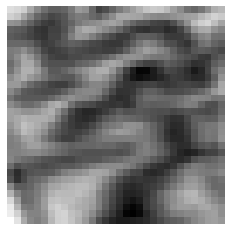

In [125]:
"""from random import randrange

index_to_view = randrange(12747)
check_vol = training_patches[index_to_view,:,:,:]

plt.axis('off')
plt.imshow(check_vol, cmap='gray')
plt.show()"""

# Data Augmentation

In [23]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        #rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        #data_format = "channels_last",
        fill_mode='nearest') #reflect, wrap, constant(black)

In [24]:
train_generator = datagen.flow(training_patches, batch_size=int(training_patches.shape[0]/BATCH_SIZE), seed=1)
train_label_generator = datagen.flow(training_patches_seg, batch_size=int(training_patches.shape[0]/BATCH_SIZE), seed=1)

val_generator = datagen.flow(validation_patches, batch_size=int(validation_patches.shape[0]/BATCH_SIZE), seed=1)
val_label_generator = datagen.flow(validation_patches_seg, batch_size=int(validation_patches.shape[0]/BATCH_SIZE), seed=1)

In [25]:
X_train = train_generator.next()
y_train = train_label_generator.next()

X_val = val_generator.next()
y_val = val_label_generator.next()

In [26]:
print(training_patches.shape)
print(training_patches_seg.shape)
print("----------------")
print(validation_patches.shape)
print(validation_patches_seg.shape)

(12747, 32, 32, 1)
(12747, 32, 32, 4)
----------------
(5585, 32, 32, 1)
(5585, 32, 32, 4)


In [27]:
full_train = np.concatenate((training_patches, X_train))
print(full_train.shape)
full_train_label = np.concatenate((training_patches_seg, y_train))
print(full_train_label.shape)

full_val = np.concatenate((validation_patches, X_val))
print(full_val.shape)
full_val_label = np.concatenate((validation_patches_seg, y_val))
print(full_val_label.shape)

(12946, 32, 32, 1)
(12946, 32, 32, 4)
(5672, 32, 32, 1)
(5672, 32, 32, 4)


# Train the Model

**Instantiate UNet model and train it**


Using callbacks to stop training and avoid overfitting


*   Early stopping with a certain patience
*   Save (and load!) best model



In [28]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=PATIENCE), # early stopping
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FNAME_PATTERN, save_best_only=True) # save the best based on validation
]

unet = get_unet()
unet.compile(optimizer=OPTIMISER, loss=LOSS)
unet.fit(
    x=full_train, 
    y=full_train_label,
    validation_data=(full_val, full_val_label),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=my_callbacks,
    verbose=1)

2022-01-13 22:34:55.945469: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-13 22:34:55.945675: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/200


2022-01-13 22:34:56.158473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - ETA: 0s - loss: 1.1122

2022-01-13 22:35:07.015792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 13s 64ms/step - loss: 1.1122 - val_loss: 0.5668
Epoch 2/200
203/203 [==============================] - 13s 65ms/step - loss: 0.5073 - val_loss: 0.4584
Epoch 3/200
203/203 [==============================] - 13s 65ms/step - loss: 0.4260 - val_loss: 0.3978
Epoch 4/200
203/203 [==============================] - 13s 65ms/step - loss: 0.3729 - val_loss: 0.3739
Epoch 5/200
203/203 [==============================] - 13s 64ms/step - loss: 0.3388 - val_loss: 0.3846
Epoch 6/200
203/203 [==============================] - 13s 64ms/step - loss: 0.3247 - val_loss: 0.3214
Epoch 7/200
203/203 [==============================] - 13s 64ms/step - loss: 0.3001 - val_loss: 0.3164
Epoch 8/200
203/203 [==============================] - 13s 63ms/step - loss: 0.2841 - val_loss: 0.2955
Epoch 9/200
203/203 [==============================] - 13s 63ms/step - loss: 0.2641 - val_loss: 0.2832
Epoch 10/200
203/203 [==============================] - 13s 64ms/step - loss: 0.2535 

# Load the best model

In [29]:
unet = get_unet(
    img_size=(IMAGE_SIZE[1], IMAGE_SIZE[2]),
    n_classes=N_CLASSES,
    n_input_channels=N_INPUT_CHANNELS)
unet.compile(optimizer=OPTIMISER, loss=LOSS)
unet.load_weights('model-200-categorical_crossentropy.h5')

# Evaluate on Validation Data

##Prepare test data using the validation volumes

In [30]:
def prepare_val_data(the_volumes, the_labels):

    testing_volumes_processed = the_volumes.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
    testing_labels_processed = the_labels.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])

    testing_labels_processed = tf.keras.utils.to_categorical(testing_labels_processed, num_classes=4, dtype='float32')

    #print(testing_volumes_processed.shape)
    #print(testing_labels_processed.shape)

    return (testing_volumes_processed, testing_labels_processed)

###Predict labels for validation data

In [31]:
def pred_val_data(testing_volumes_processed)  :

    # creates probability map of each label for all volumes
    prediction = unet.predict(x=testing_volumes_processed)

    prediction = np.argmax(prediction, axis=3)

    #plt.axis('off')
    #plt.imshow(prediction[:, :, 150])

    return prediction

##Computing Dice, AVD and HD for the validation data



In [32]:
def compute_hausdorff_distance(in1, in2, label):
    in1=in1.squeeze()
    in2=in2.squeeze()
    hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()
    if label == 'all':
        # Hausdorff distance
        hausdorff_distance_filter.Execute(in1, in2)
    else:
        in1_array  = in1 #sitk.GetArrayFromImage(in1)
        in1_array = (in1_array == label) *1 
        in1_array = in1_array.astype('uint16')  
        img1 = sitk.GetImageFromArray(in1_array)
        
        in2_array  = in2 #sitk.GetArrayFromImage(in2)
        in2_array = (in2_array == label) *1 
        in2_array = in2_array.astype('uint16')  
        img2 = sitk.GetImageFromArray(in2_array)
        # Hausdorff distance
        hausdorff_distance_filter.Execute(img1, img2)
    return hausdorff_distance_filter.GetHausdorffDistance()

def compute_dice_coefficient(in1, in2, label):
    in1=in1.squeeze()
    in2=in2.squeeze()
    if label=='all': 
        return 2 * np.sum( (in1>0) &  (in2>0) & (in1 == in2)) / (np.sum(in1 > 0) + np.sum(in2 > 0))
    else:
        return 2 * np.sum((in1 == label) & (in2 == label)) / (np.sum(in1 == label) + np.sum(in2 == label))

def compute_volumentric_difference(in1, in2, label):
    in1=in1.squeeze()
    in2=in2.squeeze()
    if label  == 'all':
      #  vol_dif  = np.sum((in1 != in2) & (in1 !=0) & (in2 !=0))
        return np.sum((in1 != in2)) / ((np.sum(in1 > 0) + np.sum(in2 > 0)))
    else:
        in1  = (in1 == label) * 1
        in2  = (in2 == label) * 1
        return np.sum((in1 != in2)) / ((np.sum(in1 > 0) + np.sum(in2 > 0)))

In [33]:
for cl in range(0,4,1): 
    
    overallDSC = np.zeros(N_CLASSES)
    overall_Hausdorff = np.zeros(N_CLASSES)
    overall_vol = np.zeros(N_CLASSES)
    

    for i in range(0,validation_volumes.shape[0], 1):

        testing_volumes_processed, testing_labels_processed = prepare_val_data(v_volumes[i], v_labels[i])
        prediction = pred_val_data(testing_volumes_processed)
        
        if (cl == 0):
            
            name = list_id[i]
            temp_img = nib.load('data/Validation_Set/{}/{}.nii.gz'.format(name, name))

            image_to_save = nib.Nifti1Image(prediction, temp_img.affine)
            image_to_save.set_data_dtype(np.uint16)

            #print(image_to_save.shape)
            nib.save(image_to_save, 'our_code_validated_seg/our_{0}.nii.gz'.format(name))
        #cl = 3
        
        cur_DSC = compute_dice_coefficient(prediction, v_labels[i], label=cl)
        overallDSC = overallDSC + cur_DSC

        cur_Hausdorff = compute_hausdorff_distance(prediction, v_labels[i], label=cl) 
        overall_Hausdorff = overall_Hausdorff + cur_Hausdorff

        cur_vol = compute_volumentric_difference(prediction, v_labels[i], label=cl)
        overall_vol = overall_vol + cur_vol

        #print(prediction.shape)
        #print(v_labels[i].shape)

    #print(overall_Hausdorff)
    overallDSC = overallDSC/validation_volumes.shape[0]
    overall_Hausdorff = overall_Hausdorff/validation_volumes.shape[0]
    overall_vol = overall_vol/validation_volumes.shape[0]

    print("Class {}".format(cl))
    print("\tDice Coefficient = {:.4f}".format(overallDSC[i]))
    print("\tHD = {:.4f}".format(overall_Hausdorff[i]))
    print("\tAVD = {:.4f}".format(overall_vol[i]))

2022-01-13 22:49:30.006304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Class 0
	Dice Coefficient = 0.9968
	HD = 20.7774
	AVD = 0.0032
Class 1
	Dice Coefficient = 0.8220
	HD = 136.1081
	AVD = 0.1780
Class 2
	Dice Coefficient = 0.9163
	HD = 87.7016
	AVD = 0.0837
Class 3
	Dice Coefficient = 0.8814
	HD = 121.2623
	AVD = 0.1186
